<a href="https://colab.research.google.com/github/seokhee516/Cat-Behavior-Classification-Project/blob/main/cat_behavior_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 분석을 위한 코랩 환경 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -qq /content/drive/MyDrive/Cat_Project/dataset/dataset.zip

# 1. 모듈 불러오기


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
from sklearn.metrics import classification_report, confusion_matrix

import cv2
import urllib
import requests
from io import BytesIO
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import img_to_array

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Requirements 제작
pip freeze > requirements.txt

# 2. 합성곱 연산
## 2차원 이미지 합성곱 연산

In [ ]:
# url을 이미지로 바꿔주는 함수
def url_to_image(url, gray=False):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  print(image)
  
  if gray == True:
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
  else:
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  return image

# 로컬 경로에 저장된 이미지를 불러오는 함수
def path_to_image(path, gray= False):
  with open(path, 'rb') as f:
    data = f.read()
  image = np.fromstring(data, dtype="uint8")

  if gray == True:
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
  else:
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  return image

# 필터 처리된 이미지를 만드는 함수
def filtered_image(image, filter, output_size):
  filtered_img = np.zeros((output_size, output_size))
  filter_size = filter.shape[0]

  for i in range(output_size):
    for j in range(output_size):
      multyply_values = image[i:(i+filter_size), j:(j+filter_size)] * filter
      sum_value = np.sum(multyply_values)

      if (sum_value > 255):
        sum_value = 255
      
      filtered_img[i, j] = sum_value

  return filtered_img

image.shape (183, 275)


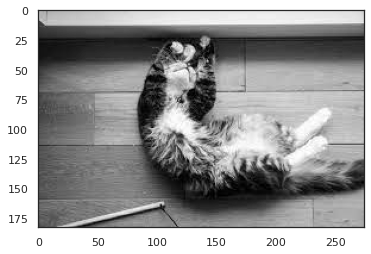

In [ ]:
img_path = "/content/drive/MyDrive/Cat_Project/roll_test_image.jpg"

image = path_to_image(img_path, gray=True)
print("image.shape", image.shape)

plt.imshow(image, cmap='gray')
plt.show()

output size: 181


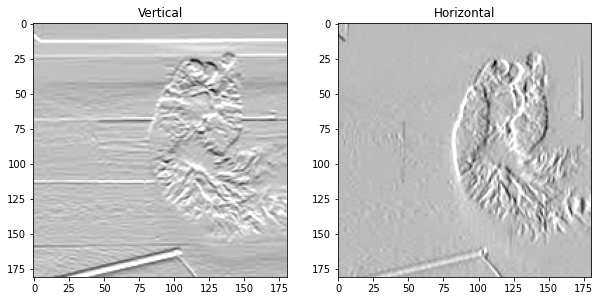

In [ ]:
# Vertical, Horizontal 필터 적용
vertical_filter = np.array([[1., 2., 1.], 
                            [0., 0., 0.],
                            [-1., -2., -1.]])
horizontal_filter = np.array([[1., 0., -1.],
                              [2., 0., -2.],
                              [1., 0., -1.]])

output_size = int((image.shape[0] - 3) / 1 + 1)
print("output size:", output_size)

vertical_filtered = filtered_image(image, vertical_filter, output_size)
horizontal_filtered = filtered_image(image, horizontal_filter, output_size)

plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.title("Vertical")
plt.imshow(vertical_filtered, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Horizontal")
plt.imshow(horizontal_filtered, cmap='gray')


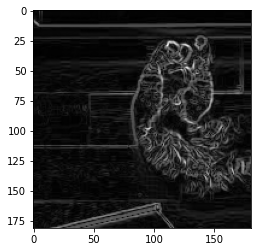

In [ ]:
# Sobel 필터로 가장자리 강조 이미지 생성
sobel_img = np.sqrt(np.square(horizontal_filtered) + np.square(vertical_filtered))

plt.imshow(sobel_img, cmap='gray');

## 3차원 이미지 합성곱 연산

image.shape


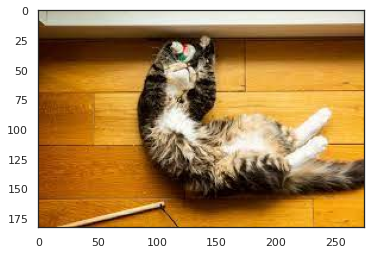

In [ ]:
img_path = "/content/drive/MyDrive/Cat_Project/roll_test_image.jpg"

image = path_to_image(img_path)
print("image.shape")

plt.imshow(image)
plt.show()

In [ ]:
# RGB grayscale
image_copy = image.copy()
image_copy[:, :, 1] = 0
image_copy[:, :, 2] = 0
image_red = image_copy

In [ ]:
image_copy = image.copy()
image_copy[:, :, 0] = 0
image_copy[:, :, 2] = 0
image_green = image_copy

In [ ]:
image_copy = image.copy()
image_copy[:, :, 0] = 0
image_copy[:, :, 1] = 0
image_blue = image_copy

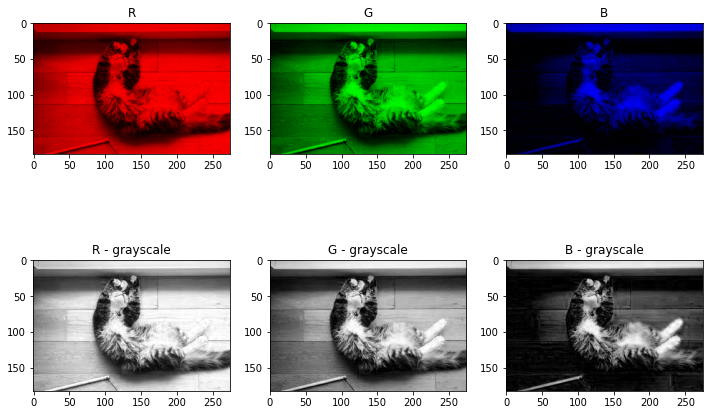

In [ ]:
fig = plt.figure(figsize=(12, 8))
title_list = ['R', 'G', 'B',
              'R - grayscale', 'G - grayscale', 'B - grayscale']
image_list = [image_red, image_green, image_blue,
              image_red[:, :, 0], image_green[:, :, 1], image_blue[:, :, 2]]
for i, image in enumerate(image_list):
  ax = fig.add_subplot(2,3,i+1)
  ax.title.set_text("{}".format(title_list[i]))

  if i >=3:
    plt.imshow(image, cmap = 'gray')
  else:
    plt.imshow(image)

plt.show()

# 3. 모델링

## 데이터셋 로드

In [4]:
# 코랩 환경에 저장된 dataset 경로
train_dir = '/content/train'
val_dir = '/content/validation'

# 클래스 리스트 선언
class_names = ['ARCH', 'ARMSTRETCH', 'FOOTPUSH', 'GETDOWN', 'GROOMING', 'HEADING', 'LAYDOWN', 'LYING', 'ROLL', 'SITDOWN', 'TAILING', 'WALKRUN']

# 데이터 매개변수 정의
batch_size=16

# Train dataset 생성
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    seed=10,
    batch_size=batch_size
)

# Validation dataset 생성
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    seed=10,
    batch_size=batch_size
)
train_ds, val_ds

Found 10072 files belonging to 12 classes.
Found 2525 files belonging to 12 classes.


(<BatchDataset shapes: ((None, 256, 256, 3), (None, 12)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 256, 256, 3), (None, 12)), types: (tf.float32, tf.float32)>)

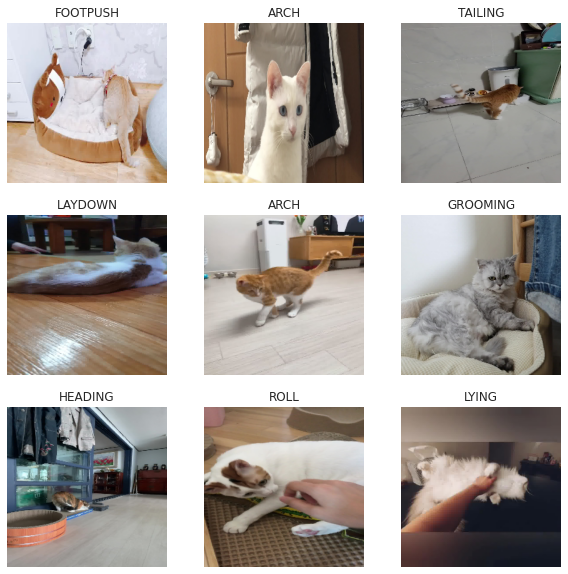

In [ ]:
# Train Dataset의 이미지와 True Label 출력
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i].numpy())])
    plt.axis("off")

## baseline 모델

In [5]:
# 분류 클래스 개수 지정
num_classes = 12

In [6]:
# 베이스라인 모델 생성
baseline_model = Sequential([Rescaling(1./255),
                             Conv2D(32, (3,3), padding='same', activation='relu'),
                             MaxPooling2D(3, 3),
                             Conv2D(64, (3,3), padding='same', activation='relu'),
                             MaxPooling2D(3,3),
                             Conv2D(128, (3,3), padding='same', activation='relu'),
                             MaxPooling2D(3,3),
                             Conv2D(256, (3,3), padding='same', activation='relu'),
                             Dropout(0.2),
                             MaxPooling2D(3,3),
                             Flatten(),
                             Dense(128, activation='relu'),
                             Dense(num_classes, activation='softmax')
                             ])
# 모델 컴파일
baseline_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [7]:
# ModelCheckpoint 생성
check_point_cb = ModelCheckpoint('baseline_model.h5', save_best_only=True)

# EarlyStopping 지정
early_stopping_cb = EarlyStopping(patience=3, monitor='val_loss')

# 모델 학습, 학습 과정 기록을 위해 history 변수 생성 
baseline_history = baseline_model.fit(train_ds, 
                                      validation_data=val_ds, 
                                      epochs=30, 
                                      callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/30
630/630 [==============================] - 38s 46ms/step - loss: 0.9627 - accuracy: 0.6820 - val_loss: 5.4645 - val_accuracy: 0.1046
Epoch 2/30
630/630 [==============================] - 29s 46ms/step - loss: 0.0989 - accuracy: 0.9715 - val_loss: 7.7209 - val_accuracy: 0.0958
Epoch 3/30
630/630 [==============================] - 29s 45ms/step - loss: 0.0605 - accuracy: 0.9821 - val_loss: 7.9415 - val_accuracy: 0.0519
Epoch 4/30
630/630 [==============================] - 29s 45ms/step - loss: 0.0556 - accuracy: 0.9853 - val_loss: 8.5617 - val_accuracy: 0.0479


In [8]:
# 학습 결과 시각화를 위한 함수 
def history_plot(model_history):
  history_dict = model_history.history

  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  epochs = range(1, len(loss) + 1)
  fig = plt.figure(figsize=(12, 6))

  ax1 = fig.add_subplot(1,2,1)
  ax1.plot(epochs, loss, color = 'blue', label='train_loss')
  ax1.plot(epochs, val_loss, color='red', label = 'val_loss')
  ax1.set_title('Train and Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  accuracy = history_dict['accuracy']
  val_accuracy = history_dict['val_accuracy']

  ax2 = fig.add_subplot(1,2,2)
  ax2.plot(epochs, accuracy, color = 'blue', label='train_accuracy')
  ax2.plot(epochs, val_accuracy, color='red', label = 'val_accuracy')
  ax2.set_title('Train and Validation accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.grid()
  ax2.legend()

  plt.show()
  return

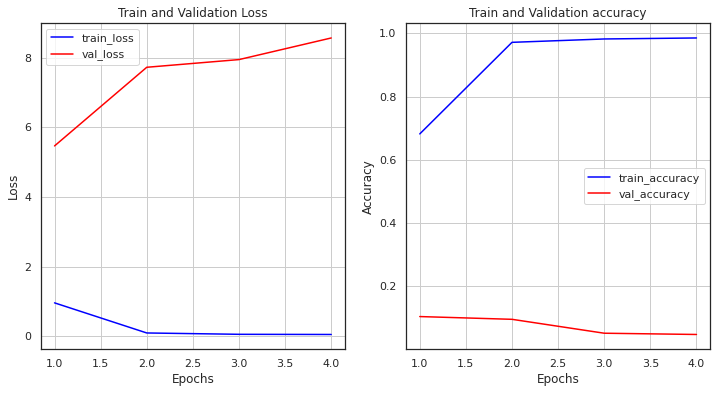

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

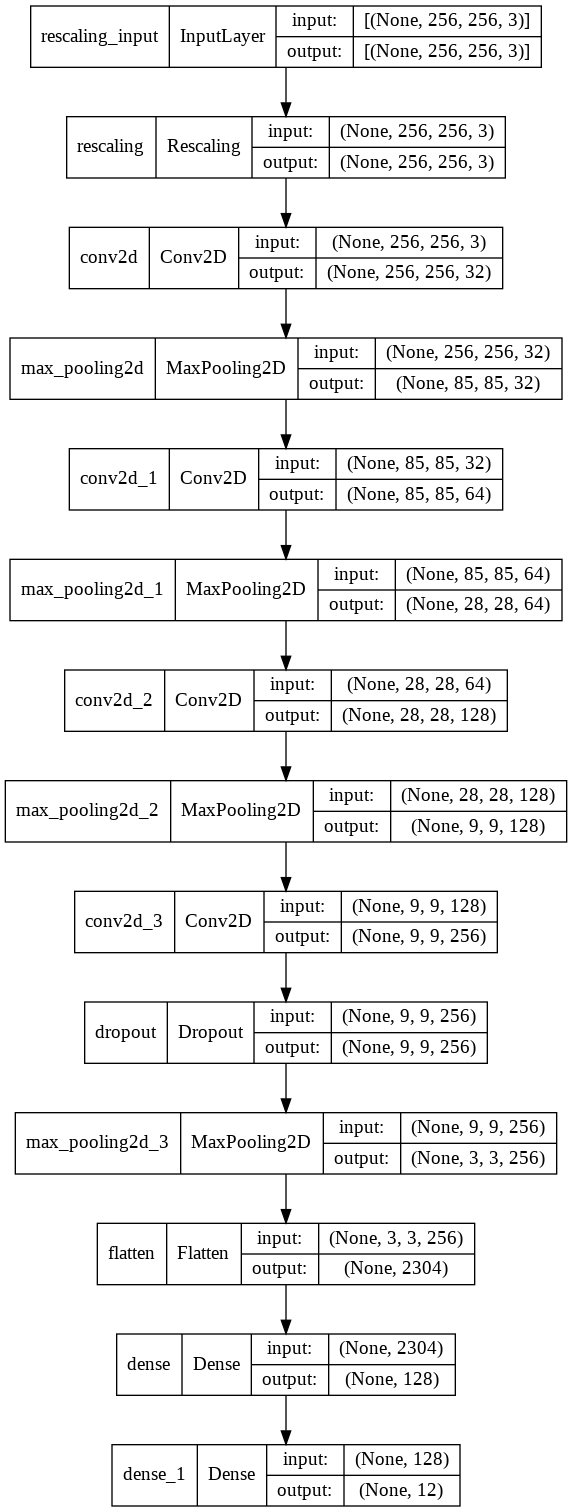

In [9]:
# 학습 과정 시각화
history_plot(baseline_history)

# 모델 레이어 summary
baseline_model.summary()

# 모델 레이어 시각화
plot_model(baseline_model, to_file='baseline_model.png', show_shapes=True)

## Custom 모델

In [10]:
# 레이어를 추가한 custom 모델 생성
custom_model= Sequential([Rescaling(1./255),
                          Conv2D(32, (3,3), padding='same', activation='relu'),
                          MaxPooling2D(3, 3),
                          BatchNormalization(), # 배치 정규화
                          Dense(512,activation='relu'), 
                          Dropout(0.3),
                          Conv2D(64, (3,3), padding='same', activation='relu'),
                          MaxPooling2D(3,3),
                          BatchNormalization(),
                          Dense(512,activation='relu'), 
                          Dropout(0.3),
                          Conv2D(128, (3,3), padding='same', activation='relu'),
                          MaxPooling2D(3,3),
                          Conv2D(256, (3,3), padding='same', activation='relu'),
                          Dropout(0.3),
                          MaxPooling2D(3,3),
                          Flatten(),
                          Dense(128, activation='relu'),
                          Dense(num_classes, activation='softmax')
                          ])
# 모델 컴파일
custom_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# ModelCheckpoint 생성
check_point_cb = ModelCheckpoint('custom_model.h5', save_best_only=True)

# EarlyStopping 지정
early_stopping_cb = EarlyStopping(patience=5, monitor='val_loss')

# 모델 학습, 학습 과정 기록을 위해 history 변수 생성 
custom_history = custom_model.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=30,
                                  callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/30
630/630 [==============================] - 42s 63ms/step - loss: 0.6007 - accuracy: 0.8144 - val_loss: 6.1593 - val_accuracy: 0.1093
Epoch 2/30
630/630 [==============================] - 39s 61ms/step - loss: 0.0965 - accuracy: 0.9725 - val_loss: 7.8363 - val_accuracy: 0.1477
Epoch 3/30
630/630 [==============================] - 39s 61ms/step - loss: 0.1073 - accuracy: 0.9690 - val_loss: 7.5019 - val_accuracy: 0.1141
Epoch 4/30
630/630 [==============================] - 39s 62ms/step - loss: 0.0556 - accuracy: 0.9826 - val_loss: 7.8452 - val_accuracy: 0.1533
Epoch 5/30
630/630 [==============================] - 39s 62ms/step - loss: 0.0622 - accuracy: 0.9836 - val_loss: 10.2116 - val_accuracy: 0.0630
Epoch 6/30
630/630 [==============================] - 39s 62ms/step - loss: 0.0687 - accuracy: 0.9821 - val_loss: 10.1077 - val_accuracy: 0.0962


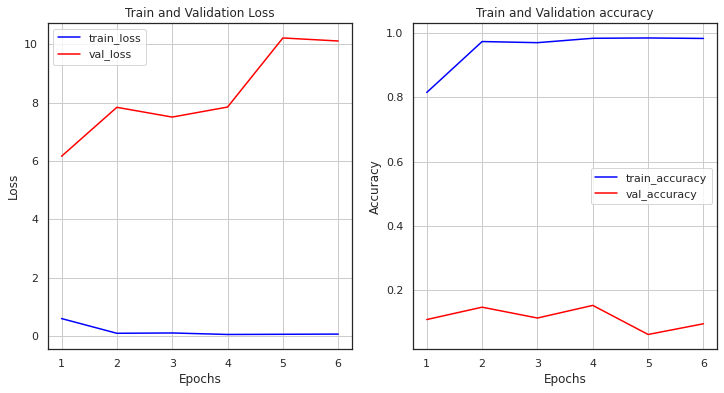

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 85, 85, 32)       128       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 85, 85, 512)       16896     
                                                                 
 dropout_1 (Dropout)         (None, 85, 85, 512)      

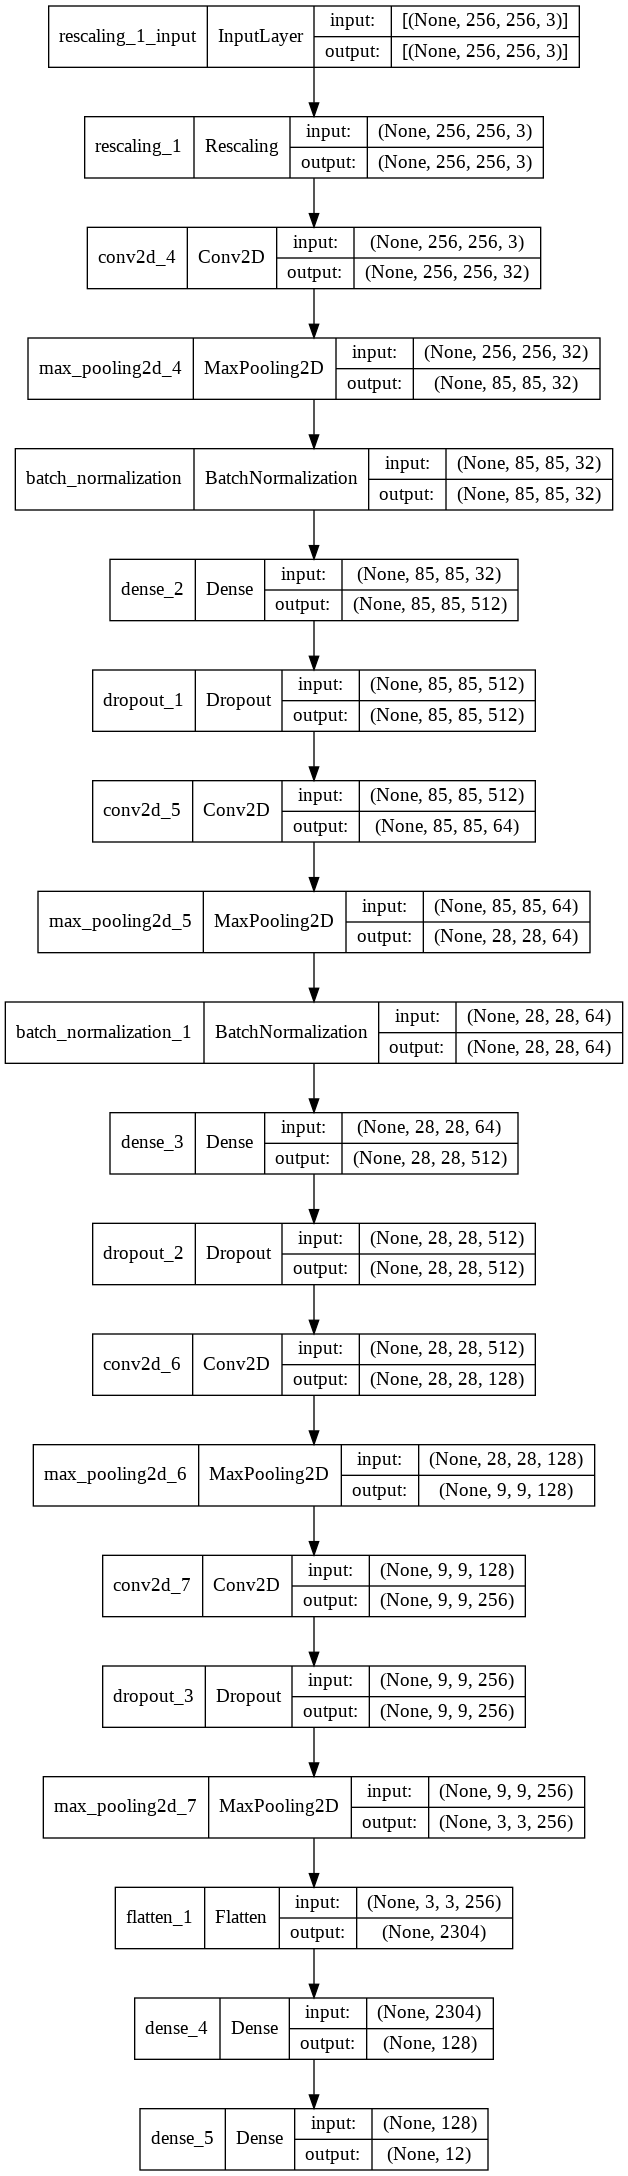

In [12]:
# 학습 과정 시각화
history_plot(custom_history)

# 모델 레이어 summary
custom_model.summary()

# 모델 레이어 시각화
plot_model(custom_model, to_file='custom_model.png', show_shapes=True)

## ResNet50

In [ ]:
# 사전 학습된 ResNet을 통한 전이학습
resnet = ResNet50(weights='imagenet', include_top=False)
# 사전 학습 가중치는 학습되지 않도록 고정
for layer in resnet.layers:
    layer.trainable = False

# 모델 생성
# 사전 학습 모델 위에 완전 연결 신경망을 추가
resnet_model = Sequential([resnet, 
                           GlobalAveragePooling2D(),
                           Dense(128,activation='relu'),
                           Dropout(0.3),
                           Dense(num_classes,activation='softmax')
                           ])
# 모델 컴파일
resnet_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# ModelCheckpoint 생성
check_point_cb = ModelCheckpoint('resnet_model.h5', save_best_only=True)

# EarlyStopping 지정
early_stopping_cb = EarlyStopping(patience=5, monitor='val_loss')

# 모델 학습, 학습 과정 기록을 위해 history 변수 생성 
resnet_history = resnet_model.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=30,
                                  callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/30
630/630 [==============================] - 46s 67ms/step - loss: 0.4251 - accuracy: 0.8809 - val_loss: 3.3094 - val_accuracy: 0.2404
Epoch 2/30
630/630 [==============================] - 40s 64ms/step - loss: 0.0495 - accuracy: 0.9881 - val_loss: 3.8525 - val_accuracy: 0.2305
Epoch 3/30
630/630 [==============================] - 40s 63ms/step - loss: 0.0232 - accuracy: 0.9942 - val_loss: 4.4138 - val_accuracy: 0.1996
Epoch 4/30
630/630 [==============================] - 40s 63ms/step - loss: 0.0289 - accuracy: 0.9912 - val_loss: 4.4152 - val_accuracy: 0.2099
Epoch 5/30
630/630 [==============================] - 40s 63ms/step - loss: 0.0327 - accuracy: 0.9884 - val_loss: 5.6401 - val_accuracy: 0.2444
Epoch 6/30
630/630 [==============================] - 41s 64ms/step - loss: 0.0233 - accuracy: 0.9923 - val_loss: 6.2334 - val_accuracy: 0.2321


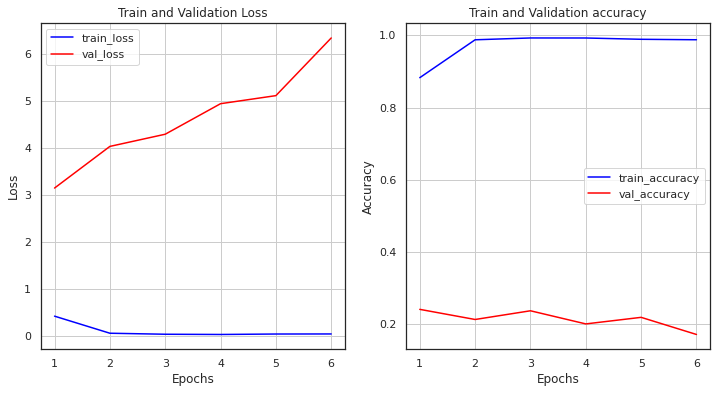

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_38 (Dense)            (None, 128)               262272    
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 12)                1548      
                                                                 
Total params: 23,851,532
Trainable params: 263,820
Non-trainable params: 23,587,712
___________________________________

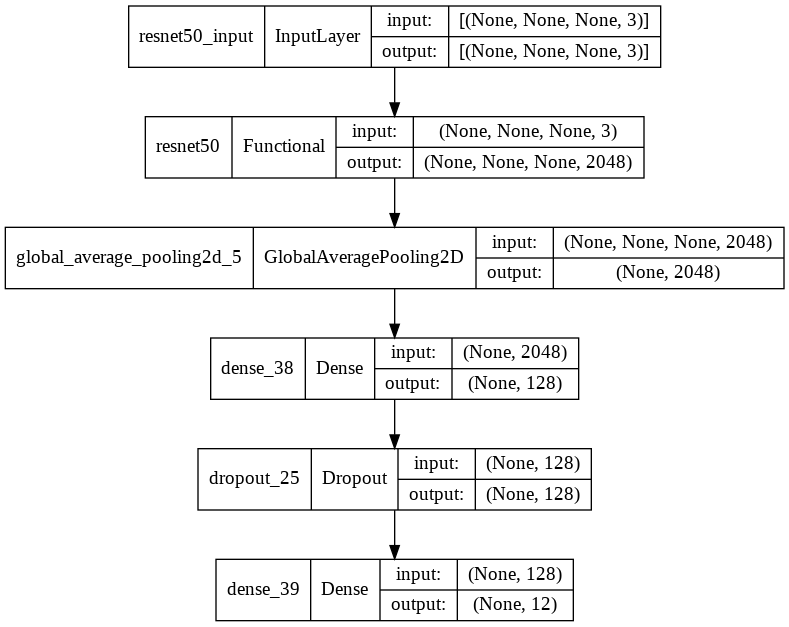

In [ ]:
# 학습 과정 시각화
history_plot(resnet_history)

# 모델 레이어 summary
resnet_model.summary()

# 모델 레이어 시각화
plot_model(resnet_model, to_file='resnet_model.png', show_shapes=True)

## VGG16

In [ ]:
# 사전 학습된 VGG16 모델 불러오기
vgg = VGG16(weights='imagenet', include_top=False)

# 사전 학습 가중치는 학습되지 않도록 고정
for layer in vgg.layers:
    layer.trainable = False


# 모델 생성
# 사전 학습 모델 위에 완전 연결 신경망을 추가
vgg_model = Sequential([vgg, 
                        GlobalAveragePooling2D(), 
                        Dense(128,activation='relu'),
                        Dropout(0.3),
                        Dense(num_classes,activation='softmax')
])

# 모델 컴파일
vgg_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# ModelCheckpoint 생성
check_point_cb = ModelCheckpoint('vgg_model.h5', save_best_only=True)

# EarlyStopping 지정
early_stopping_cb = EarlyStopping(patience=5, monitor='val_loss')

# 모델 학습, 학습 과정 기록을 위해 history 변수 생성 
vgg_history = vgg_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=30,
                            callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/30
630/630 [==============================] - 40s 61ms/step - loss: 0.7028 - accuracy: 0.8192 - val_loss: 4.0427 - val_accuracy: 0.2376
Epoch 2/30
630/630 [==============================] - 38s 60ms/step - loss: 0.0811 - accuracy: 0.9784 - val_loss: 4.6138 - val_accuracy: 0.2301
Epoch 3/30
630/630 [==============================] - 38s 60ms/step - loss: 0.0425 - accuracy: 0.9872 - val_loss: 4.8248 - val_accuracy: 0.2281
Epoch 4/30
630/630 [==============================] - 38s 61ms/step - loss: 0.0325 - accuracy: 0.9906 - val_loss: 5.3002 - val_accuracy: 0.2412
Epoch 5/30
630/630 [==============================] - 38s 60ms/step - loss: 0.0298 - accuracy: 0.9906 - val_loss: 6.0334 - val_accuracy: 0.2071
Epoch 6/30
630/630 [==============================] - 38s 60ms/step - loss: 0.0255 - accuracy: 0.9923 - val_loss: 6.6472 - val_accuracy: 0.2523


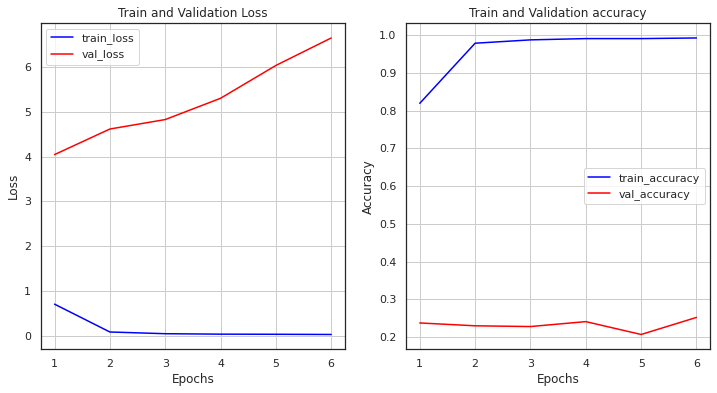

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_40 (Dense)            (None, 128)               65664     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 12)                1548      
                                                                 
Total params: 14,781,900
Trainable params: 67,212
Non-trainable params: 14,714,688
____________________________________

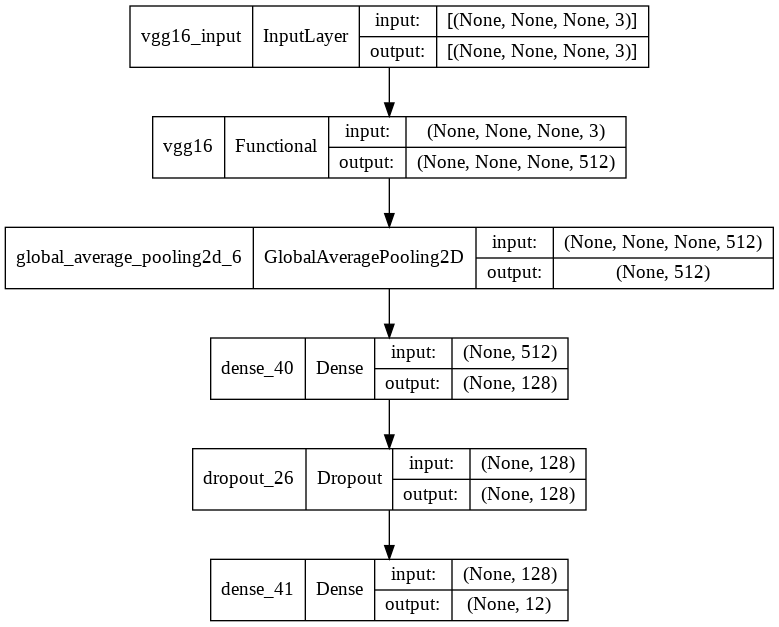

In [ ]:
# 학습 과정 시각화
history_plot(vgg_history)

# 모델 레이어 summary
vgg_model.summary()

# 모델 레이어 시각화
plot_model(vgg_model, to_file='vgg_model.png', show_shapes=True)

# 4. 모델 평가

In [ ]:
# 가장 성능이 높았던 vgg 모델 평가
model = load_model('vgg_model.h5')
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_40 (Dense)            (None, 128)               65664     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 12)                1548      
                                                                 
Total params: 14,781,900
Trainable params: 67,212
Non-trainable params: 14,714,688
____________________________________

In [ ]:
# 최종 정확도 23.7%
model.evaluate(val_ds)

158/158 [==============================] - 8s 50ms/step - loss: 4.0427 - accuracy: 0.2376


[4.042719841003418, 0.23762376606464386]

In [ ]:
# validation dataset에서 y_val 분리
pred_ys = model.predict(val_ds)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

<function matplotlib.pyplot.show>

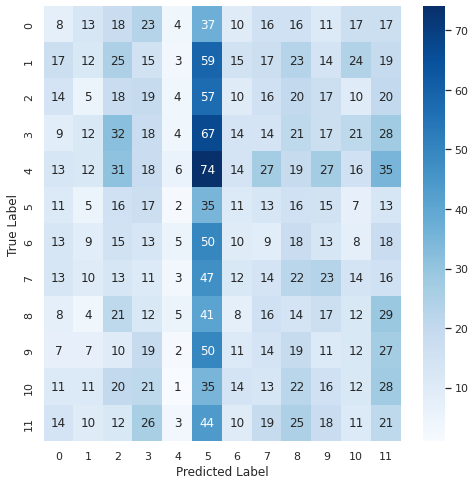

In [ ]:
# Confusion Maxtrix 를 통해 예측 시각화
plt.figure(figsize=(8, 8))
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(pred_ys, axis=-1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show

In [ ]:
# classification_report를 통해 label별 평가지표 확인
print(classification_report(np.argmax(y_val, axis=-1), np.argmax(pred_ys, axis=-1)))

              precision    recall  f1-score   support

           0       0.06      0.04      0.05       190
           1       0.11      0.05      0.07       243
           2       0.08      0.09      0.08       210
           3       0.08      0.07      0.08       257
           4       0.14      0.02      0.04       292
           5       0.06      0.22      0.09       161
           6       0.07      0.06      0.06       181
           7       0.07      0.07      0.07       198
           8       0.06      0.07      0.07       187
           9       0.06      0.06      0.06       189
          10       0.07      0.06      0.07       204
          11       0.08      0.10      0.09       213

    accuracy                           0.07      2525
   macro avg       0.08      0.08      0.07      2525
weighted avg       0.08      0.07      0.07      2525



In [ ]:
# 테스트 이미지와 예측된 라벨을 보여주는 함수
def predict_image(path, model):
  load_image = path_to_image(path)
  
  image = cv2.resize(load_image, (256,256))
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  pred = resnet_model.predict(image)
  label = class_names[pred.argmax()]

  # plt.title("predicted label: {}".format(label))

  print("Predicted Label: {}".format(label))
  print("Prediction Probability : {} %".format(round(pred.max()*100)))
  plt.imshow(load_image)

Predicted Label: TAILING
Prediction Probability : 92 %


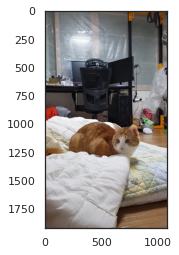

In [ ]:
# 모델을 통해 직접 이미지 분류 적용
# True Label : SITDOWN
# Predicted Label: TAILING
img_path = '/content/drive/MyDrive/Cat_Project/cat-sitdown-017074_frame_198_timestamp_6600.jpg'
predict_image(img_path, model)

Predicted Label: GETDOWN
Prediction Probability : 80 %


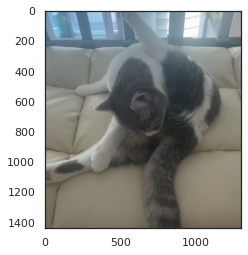

In [ ]:
# True Label : GROOMING
# Predicted Label: GETDOWN
img_path = '/content/drive/MyDrive/Cat_Project/grooming_test_image.jpg'
predict_image(img_path, model)

Predicted Label: LYING
Prediction Probability : 82 %


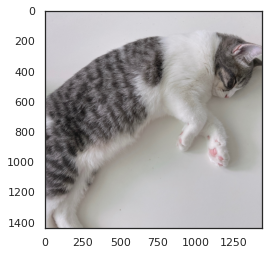

In [ ]:
# True Label : LAYDOWN
# Predicted Label: LYING
img_path = '/content/drive/MyDrive/Cat_Project/laydown_test_image.jpg'
predict_image(img_path, model)

Predicted Label: HEADING
Prediction Probability : 100 %


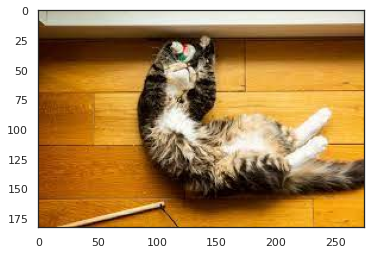

In [ ]:
# True Label : ROLL
# Predicted Label: HEADING
img_path = '/content/drive/MyDrive/Cat_Project/roll_test_image.jpg'
predict_image(img_path, model)

Predicted Label: LYING
Prediction Probability : 53 %


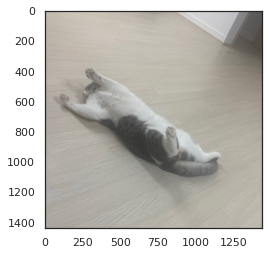

In [ ]:
# True Label : ROLL
# Predicted Label: LYING
img_path = "/content/drive/MyDrive/Cat_Project/roll_test_image2.jpg"
predict_image(img_path, model)